# Marvel Network Data

## Author: Oliver Gladfelter

### Date: Sep 10, 2020

In [2]:
import lxml.html as lh
import io
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

## Crawl And Save URLs To All 29k Earth-616 Character Pages

In [3]:
def charactersFromPage(url):
    """
    This Marvel Category section lists all the teams from the comic books. However, only 200 are shown per page.
    This function scrapes the url to each of those teams that are in the 616 universe.
    """
    
    r = requests.get(url)
    soup = BeautifulSoup(r.content, "lxml")
    
    li = soup.find('div',{'class':'category-page__members'}).findAll('li')
    
    teamURLs = []
    
    for item in li:
        teamURLs.append('http://marvel.wikia.com' + item.find('a')['href'])
            
    return teamURLs

def getPageLinksOfCategory(url):
    """
    The previous function pulls team URLs from any given category page. We now need links to each of the team category pages,
    which is necessary because each of these pages shows just 200 teams. 
    The URLs also look like "https://marvel.fandom.com/wiki/Category:Active_Teams?from=Brotherhood+%28Earth-13729%29", rather than
    "https://marvel.fandom.com/wiki/Category:Active_Teams?page=1", so we need to make use of the 'next page' button at 
    the bottom of each category page.
    
    parameters: url - url to page one of any category
    returns: list of urls to every single page in the category
    """
    
    page_links = []
    link_to_next_page = "this can be anything" # just initializing this for the loop
    
    # every category page contains 200 links, which we're collecting.
    # every page always has 'previous 200' and 'next 200' hyperlinked text, with links to
    # previous and next pages. We use these links to advance through the category pages. 
    # But when the 'next 200' text isn't on the page, this lets us know we've reached the 
    # final page and should stop
    while link_to_next_page is not None:
        r = requests.get(url)

        if r.status_code != 200:
            continue 
        else:
            soup = BeautifulSoup(r.content, "lxml")
        
        # search the page for the 'next' button and grab its hyperlink      
        link_to_next_page = soup.find('a',{'class':'category-page__pagination-next'})
        
        try:
            url = link_to_next_page['href'] # this will be used in the next iteration of the loop
        except:
            print("Last page reached!")
        page_links.append(url) # but first, save it to the array which will eventually be returned
        
    # should return a list of URLs to every page in the category, which will be used in the next step
    return page_links

In [4]:
# get list of all URLs in "Earth-616" category on the Marvel Wiki
character_pages = getPageLinksOfCategory("https://marvel.fandom.com/wiki/Category:Earth-616_Characters")

Last page reached!


In [5]:
print("This saved us from having to manually navigate to and save " + str(len(character_pages)) + " page URLs.")

This saved us from having to manually navigate to and save 146 page URLs.


In [6]:
# now, get links to each of the Earth-616 teams throughout these 11 pages
characters = []

for page in character_pages:
    characters = characters + charactersFromPage(page)
    
# convert to df
characters = pd.DataFrame(characters, columns=['url'])

In [7]:
len(characters)

29136

In [10]:
characters.to_csv("Marvel_Character_Data.csv", index=False)

## Visit every character page to grab number of comic book appearances

In [20]:
def getAppearanceCount(link):
    # note: this is searching for 'major appearances'. For characters with 0 major appearances,
    # this function will return an empty string
    
    r = requests.get(link)

    soup = BeautifulSoup(r.content, "lxml")

    uls = soup.findAll("ul")

    # the "number of appearances" is always in an unordered list
    for ul in uls:
        if re.search("Appearances of",ul.text) is not None:
            links_and_references_list = ul

    # appearance count is always first
    appearanceCount = links_and_references_list.findAll("li")[0].text
    appearanceString = re.search("\s?([\d,]{,})\sA",appearanceCount).group(1)
    
    # If a value has at least a thousand views, remove comma in the string
    return appearanceString.replace(",","")

In [ ]:
characters['appearances'] = ''

In [66]:
# using a loop here works best as there are so many requests to make
# Marvel wiki website did interupt after ~20k calls, but I was able to resume after waiting ~60 minutes
for num in range(0,len(characters)):
    characters['appearances'][num] = getAppearanceCount(characters['url'][num])

In [71]:
import winsound
for i in range(1, 15):
    winsound.Beep(i * 100, 200)

In [69]:
characters.to_csv("Marvel_Character_Data.csv", index=False)

## Subset to 750 Characters With The Most Appearances

In [92]:
# removing the 8% of characters who had no major appearances
characters = characters[characters['appearances']!=""]

characters = characters.reset_index()
del characters['index']

# convert appearances to int
for num in range(0,len(characters)):
    characters['appearances'][num] = int(characters['appearances'][num])

# subset to only characters in at least 61 comic books
characters = characters[characters['appearances']>60]


characters = characters.sort_values('appearances', ascending=False)

characters = characters.reset_index()
del characters['index']

In [108]:
characters.to_csv("Marvel_Character_Data.csv", index=False)

## For each character, get list of comic books they've appeared in

In [143]:
def comicBooksFromPage(url):
    
    r = requests.get(url)
    soup = BeautifulSoup(r.content, "lxml")
    
    li = soup.find('div',{'class':'category-page__members'}).findAll('li')
    
    teamURLs = []
    
    for item in li:
        teamURLs.append(item.find('a')['href'])
            
    return teamURLs

def getAppearances(url):
    """
    Every Marvel character page has a "Links and References" section (unordered list). The first item is always the appearance
    count and hyperlinks to a category section of comic books that character has appeared in.
    Example: https://marvel.fandom.com/wiki/Category:Peter_Parker_(Earth-616)/Appearances
    
    This function goes to a character page, uses the title to generate a URL to their appearances, follows that URL,
    and scrapes the name of every comic book they've appeared in
    
    Parameter: url to character page
    Returns: list of comic book titles
    """
    
    # open character page
    r = requests.get(url)
    soup = BeautifulSoup(r.content, "lxml")
    
    # get page title
    page_title = soup.find('h1', {'class':'page-header__title'}).text
        
    # generate url to appearances
    character_appearances_url = "https://marvel.fandom.com/wiki/Category:{}/Appearances".format(page_title.replace(" ","_"))
        
    # grab all URLs from this category
    comic_book_appearance_pages = getPageLinksOfCategory(character_appearances_url)
     
    comicBooks = []
    
    for page in comic_book_appearance_pages:
        comicBooks = comicBooks + comicBooksFromPage(page)

    # list of every comic book they've appeared in
    return comicBooks

In [ ]:
characters['appearanceList'] = ""

for num in range(0,len(characters)):
    characters['appearanceList'][num] = getAppearances(characters['url'][num])

In [156]:
characters.head(2)

,url,appearances,appearanceList
0,http://marvel.wikia.com/wiki/Peter_Parker_(Ear...,4311,"[/wiki/Amazing_Spider-Man_Vol_1_102, /wiki/Ama..."
1,http://marvel.wikia.com/wiki/Steven_Rogers_(Ea...,3581,"[/wiki/Tales_of_Suspense_Vol_1_76, /wiki/Aveng..."


In [155]:
characters.to_csv("Marvel_Character_Data.csv", index=False)

## Use list intersections to get number of common comic book appearances between all possible character pairs

In [158]:
character1 = []
character2 = []
numConnections = []

for num in range(0,len(characters)):
    # for loop starts with num to avoid finding intersections for characters we've already covered 
    for num2 in range(num,len(characters)):
        if characters['url'][num] == characters['url'][num2]:
            continue
        character1.append(characters['url'][num])
        character2.append(characters['url'][num2])
        numConnections.append(len(set(characters['appearanceList'][num]).intersection(characters['appearanceList'][num2])))

# construct a pd showing how many common appearances every possible combination of 2 characters have
network = pd.DataFrame({'url1':character1,'url2':character2,'numConnections':numConnections})

In [164]:
len(network) # should be around len(characters)^2 / 2

292992

In [174]:
network.sort_values('numConnections',ascending=False).head(3)

,url1,url2,numConnections
3818,http://marvel.wikia.com/wiki/Benjamin_Grimm_(E...,http://marvel.wikia.com/wiki/Jonathan_Storm_(E...,1412
3815,http://marvel.wikia.com/wiki/Benjamin_Grimm_(E...,http://marvel.wikia.com/wiki/Reed_Richards_(Ea...,1407
765,http://marvel.wikia.com/wiki/Steven_Rogers_(Ea...,http://marvel.wikia.com/wiki/Anthony_Stark_(Ea...,1370


In [178]:
network = network[network['numConnections'] != 0] # this removed 54% of rows for me
network = network.reset_index()
del network['index']

network.to_csv("num_connections_between_character_pairs.csv", index=False)

## Use TSN-E to compute (x,y) coordinates for each character

In [179]:
# convert network df into matrix
network = network.pivot_table(columns='url2', index='url1', values='numConnections').reset_index()

# fill missing connections with 0 - there are no common appearances
network = network.fillna(0)

# check network shape
print(network.shape)

# save url1 column, then drop it from matrix since it's non-numeric and can't go into TSN-E algorithm
character_coordinates = network[['url1']]
network = network.drop(['url1'], axis=1)

# TSNE stuff
from sklearn.manifold import TSNE
m = TSNE(learning_rate=50)

tsne_features = m.fit_transform(network)

# sanity check: each character should have one set of tsne_features values
assert(len(tsne_features) == len(network))

# for each character, apply their (x,y) coordinates
character_coordinates['x'] = tsne_features[:,0]
character_coordinates['y'] = tsne_features[:,1]

(753, 763)


## Viz Test

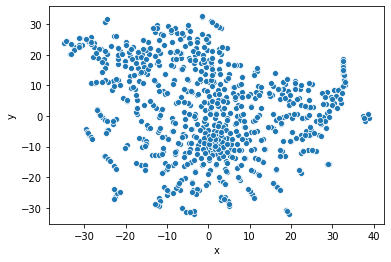

In [182]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x="x", y="y", data=character_coordinates)
plt.show()

## Merge character & character_coordinates dataframes

In [188]:
# merge to combine # of appearances and (x,y) coordinates
data = characters.merge(character_coordinates, left_on='url', right_on='url1')
data = data[['url', 'appearances', 'x', 'y']]

# save
data.to_csv("Marvel_Character_Data.csv", index=False)

In [187]:
data.head(2)

,url,appearances,x,y
0,http://marvel.wikia.com/wiki/Peter_Parker_(Ear...,4311,-34.798626,23.953491
1,http://marvel.wikia.com/wiki/Steven_Rogers_(Ea...,3581,-34.427849,24.666586


## Scrape each character page for profile picture and meta data
### Meta data being: super hero mantle name, legal full name, team affiliations

In [189]:
def get_super_name(soup):
    """
    All character pages list the character's birth/legal name as its title
    For example, Captain America's main page is titled "Steven Rogers"
    This function collects each individual's superhero name
    """
    
    return soup.find('h2',{'pi-item pi-item-spacing pi-title'}).text

def get_full_name(soup):
    """
    Several characters have nicknames. For example, we all know Ironman
    to be the superhero name of Tony Stark, but Stark's birth/legal name is
    "Anthony Stark", which is the name we originally collected. This function
    collects characters' full names, which include their nickname
    """
    
    name = soup.find('div',{'class':'pi-data-value pi-font'}).text
    
    # Removing citation notation and leading space
    name = name.replace(" [1]","").strip(" ")
    name = name.replace("[1]","")
    name = name.replace(" [2]","")
    name = name.replace("[2]","")
    name = name.replace(" [3]","")
    return name.replace("[3]","")

def nickName(fullName):
    """
    Parses a nickname out of a full name, if a character has a nickname
    """
    
    if fullName == -1:
        return fullName
    
    # No listed nickname in full name
    if re.search("[\"\'](.{,})[\"\']",fullName) is None:
        return ""
    
    # Return nickname + last name
    nickName = re.search("[\"\'](.{,})[\"\']",fullName).group(1)
    lastName = fullName.split(" ")[-1]
    return nickName + " " + lastName

def get_affiliations(soup):
    """
    All character pages list teams/organizations the character have ever been a part of
    This function retrieves the list and returns it in a string
    """
    
    # not all characters have affiliations
    try:
        return soup.find('div', {'data-source':'Affiliation'}).find('div').text
    except:
        return -1
    
def get_meta_data(soup):
    
    super_name = get_super_name(soup)
    legal_name = get_full_name(soup)
    affiliations = get_affiliations(soup)
    
    return [super_name, legal_name, affiliations]

In [ ]:
# following for loop saves images to a local folder for front end development
# each photo will be saved with a numerical ID. This new column helps connect characters to correct photos
data['pic_id'] = ''
data['meta_data'] = ''

for num in range(0,len(data)):

    # open link to character page
    r = requests.get(data['url'][num])
    soup = BeautifulSoup(r.content, "lxml")

    ##### AVATAR PICTURE #####
    # find link to avatar picture
    image_url = soup.findAll("figure",{"class":"pi-item pi-image"})[0].find("a")['href']

    # open image, save to local folder
    img_data = requests.get(image_url).content
    with open("pictures/" + str(num) + ".jpg", 'wb') as handler:
        handler.write(img_data)  

    # save image name as a variable in dataframe for future connecting
    data['pic_id'][num] = num
    ##########################
    
    ##### META DATA #####
    
    meta_data = get_meta_data(soup)
    data['meta_data'][num] = meta_data
    
    ##########################

In [194]:
def superName(meta_data):
    return meta_data[0]

def fullName(meta_data):
    return meta_data[1]

def teams(meta_data):
    return meta_data[2]

# seperate meta data into three columns and parse nick name out of full name
data['superName'] = data['meta_data'].apply(superName)
data['fullName'] = data['meta_data'].apply(fullName)
data['nickName'] = data['fullName'].apply(nickName)
data['teams'] = data['meta_data'].apply(teams)

## Review final dataframe and save

In [200]:
data.head(3)

,url,appearances,x,y,pic_id,meta_data,superName,fullName,nickName,teams
0,http://marvel.wikia.com/wiki/Peter_Parker_(Ear...,4311,-34.798626,23.953491,0,"[Spider-Man, Peter Benjamin Parker, As Peter P...",Spider-Man,Peter Benjamin Parker,,As Peter Parker: Daily Bugle (formerly Front L...
1,http://marvel.wikia.com/wiki/Steven_Rogers_(Ea...,3581,-34.427849,24.666586,1,"[Captain America, Steven ""Steve"" Rogers, Aveng...",Captain America,"Steven ""Steve"" Rogers",Steve Rogers,Avengers (off-field leader); formerly S.H.I.E....
2,http://marvel.wikia.com/wiki/Anthony_Stark_(Ea...,3290,-34.198433,24.481848,2,"[Iron Man, Anthony Edward ""Tony"" Stark, A.I. A...",Iron Man,"Anthony Edward ""Tony"" Stark",Tony Stark,"A.I. Army; formerly Avengers, Stark Unlimited ..."


In [197]:
data.to_csv("Marvel_Character_Data.csv", index=False)